# Iris Dataset Classification Using Logistic Regression
- This is a multi-class regression problem. We use logistic regression to illustrate its use in classification problems.
- While there are several ways to handle a multi-class classification (OvR, OvO, and multinomial logistic regression) we use multinomial logistic regression.
    - OvO is computationally intensive, requiring of the order of $k^2$ models for $k$ classes while multinomial logistic regression only requires one model.
    - OvR has issues for large $k$ since we run the risk of essentially artifically unbalancing the dataset by considering one class positive and other $k-1$ classes negative. It is also more computationally intensive, requiring order of $k$ models for $k$ classes.
    - Multinomial logistic regression is simpler to understand and interpret - in the other two cases one often needs to implement additional rules to deal with clashes (for instance, there is no reason why multiple classifiers in OvO or OvR case cannot give positive results). 
- The loss function is the log-loss function, implemented in `sklearn.metrics.log_loss`.
- The performance on the test set was measured using the confusion matrix, and metrics such as precision, recall, and F1 score (macro/weighted), implemented in `sklearn.metrics.classification_report`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/iris-flower-dataset/IRIS.csv


In [2]:
iris_dataset = pd.read_csv('/kaggle/input/iris-flower-dataset/IRIS.csv')

## Looking at the Data

In [3]:
iris_dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
iris_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Note that this is a simple, clean dataset:
- There are just 150 examples in the whole dataset.
- There are no missing values in the dataset. Thus, imputation is not necessary.
- Other than the target variable (species) all the data is numerical. There are no categorical features to encode.

Before we look at the data in more detail, we keep the val/test datasets aside.

### Performing the Train/Validation/Test split

In [5]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(iris_dataset.drop('species',axis=1),
                                       iris_dataset['species'],
                                       test_size = 0.2,
                                       random_state = 42,
                                       stratify = iris_dataset['species'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,
                                                 random_state=42, stratify=y)
print(f"The shape of the training data is: X_train={X_train.shape}, y_train = {y_train.shape}")
print(f"The shape of the validation data is: X_val={X_val.shape}, y_val = {y_val.shape}")
print(f"The shape of the testing data is: X_test = {X_test.shape}, y_test = {y_test.shape}")

The shape of the training data is: X_train=(90, 4), y_train = (90,)
The shape of the validation data is: X_val=(30, 4), y_val = (30,)
The shape of the testing data is: X_test = (30, 4), y_test = (30,)


To get more information about the training set, X_train, we can look at some summary statistics of each feature, as given by `X_train.describe()`

In [6]:
X_train.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,90.000000,90.000000,90.000000,90.000000
mean,5.836667,3.007778,3.752222,1.196667
std,0.866149,0.411691,1.770623,0.762823
min,4.300000,2.000000,1.100000,0.100000
25%,5.100000,2.725000,1.600000,0.300000
50%,5.750000,3.000000,4.250000,1.300000
75%,6.400000,3.200000,5.100000,1.800000
max,7.900000,3.900000,6.900000,2.500000


Let us examine the data via a scatterplot to see if there are any outliers to deal with:

In [7]:
X_train.groupby(y_train).agg(['mean','std'])

sepal_length           sepal_width           petal_length  \
                        mean       std        mean       std         mean   
species                                                                     
Iris-setosa             4.94  0.288396    3.320000  0.346808     1.463333   
Iris-versicolor         5.96  0.494522    2.723333  0.295580     4.240000   
Iris-virginica          6.61  0.713104    2.980000  0.356612     5.553333   

                          petal_width            
                      std        mean       std  
species                                          
Iris-setosa      0.158622    0.246667  0.122428  
Iris-versicolor  0.462079    1.300000  0.164002  
Iris-virginica   0.600995    2.043333  0.240235

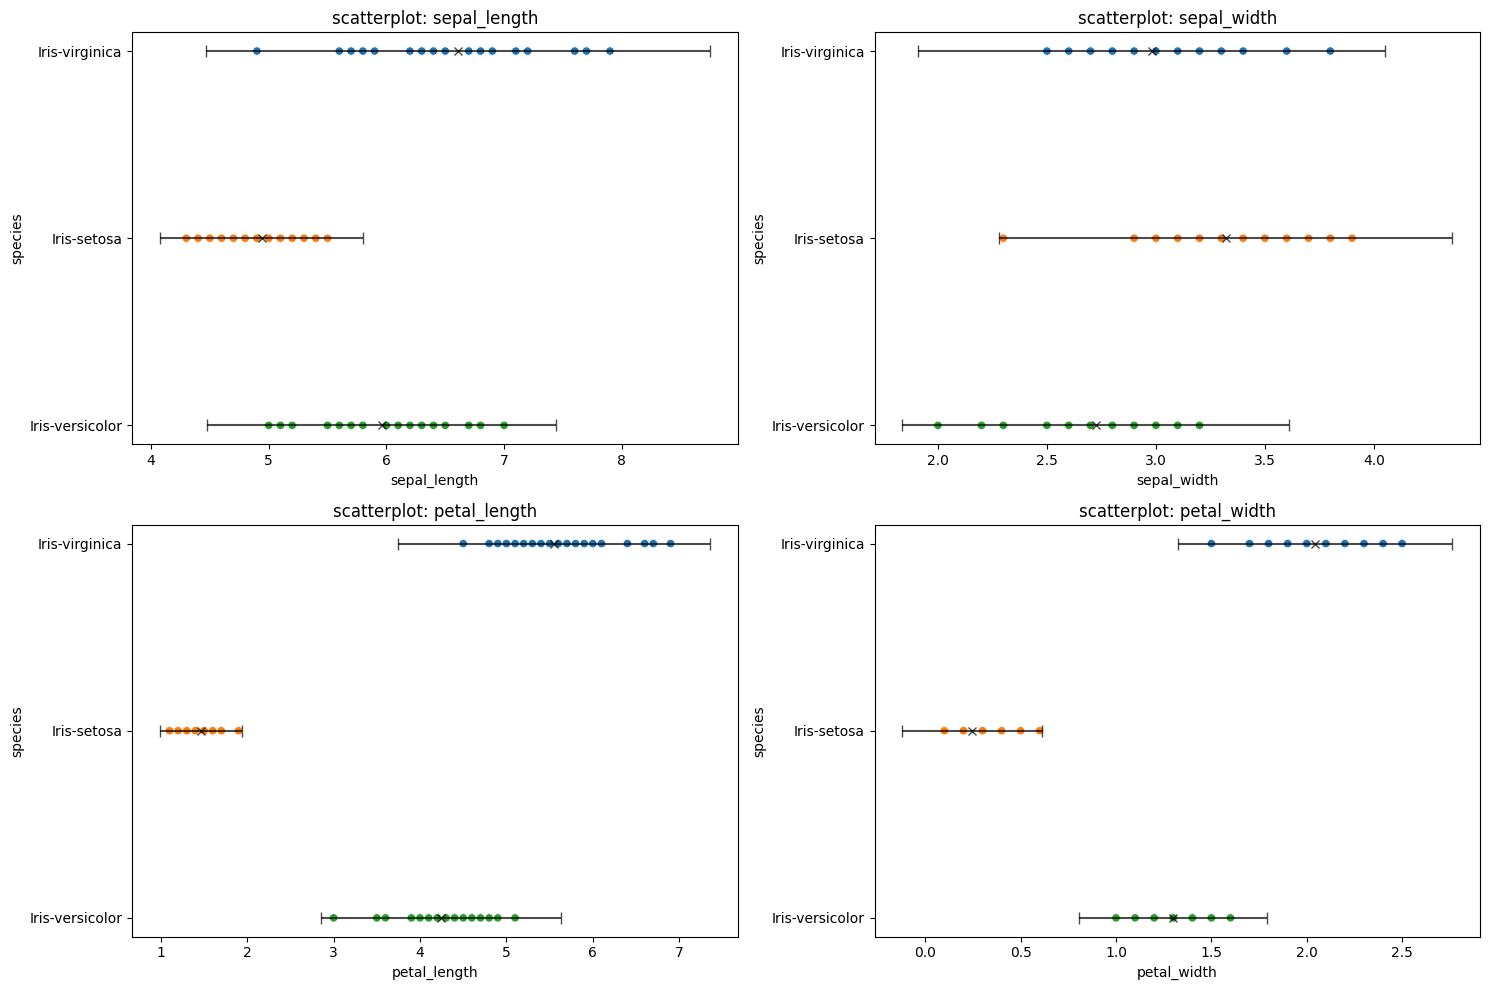

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

n_vars = X_train.shape[1]
n_cols = int(np.ceil(n_vars/2))
n_rows = int(np.ceil(n_vars/n_cols))
stats = X_train.groupby(y_train).agg(['mean','std']) # some statistics to overlay.
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*5))
axes = ax.flatten()

for i, col in enumerate(X_train.columns):
    sns.scatterplot(data=X_train, x=col, y=y_train, hue=y_train,
                   ax=axes[i])
    axes[i].set_title(f"scatterplot: {col}")
    axes[i].legend().remove()
    
    for species in y_train.unique(): # plotting errorbars
        mean_val = stats[col]['mean'][species]
        std = stats[col]['std'][species]
        axes[i].errorbar(x=mean_val, y=species, xerr=3*std, fmt='x', color='black', capsize=4, alpha=.7)
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

The error bars in the above scatterplot show $3$ standard deviations of spread. Since all points of a particular iris species lie within 3 standard deviations of the mean, we can conclude that the dataset does not have any outliers.

## Standardizing the data

Our next goal is to standardize the data, so that it has mean $0$ and variance $1$. This is important since we are using logistic regression, where the relative magnitudes of the features is important. This is in contrast to tree-based models, such as Random Forests, which are not affected by the relative size of features.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [10]:
cols = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns = cols
y_train = y_train.reset_index()['species']

cols = X_val.columns
X_val = pd.DataFrame(scaler.transform(X_val))
X_val.columns = cols
y_val = y_val.reset_index()['species']

cols = X_test.columns
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = cols
y_test = y_test.reset_index()['species']

In [11]:
X_train.describe().loc[['mean','std','min','max']].round(3)

,sepal_length,sepal_width,petal_length,petal_width
mean,0.000,-0.000,0.000,0.000
std,1.006,1.006,1.006,1.006
min,-1.784,-2.462,-1.506,-1.446
max,2.396,2.179,1.788,1.718


We can see that the scaling has worked, and we can also see the minimum and maximum values of each feature after scaling

In [12]:
X_train.groupby(y_train).agg(['mean','std','min','max']).round(3)

sepal_length                      sepal_width                \
                        mean    std    min    max        mean    std    min   
species                                                                       
Iris-setosa           -1.041  0.335 -1.784 -0.391       0.763  0.847 -1.729   
Iris-versicolor        0.143  0.574 -0.971  1.351      -0.695  0.722 -2.462   
Iris-virginica         0.898  0.828 -1.087  2.396      -0.068  0.871 -1.240   

                       petal_length                      petal_width         \
                   max         mean    std    min    max        mean    std   
species                                                                       
Iris-setosa      2.179       -1.300  0.090 -1.506 -1.052      -1.252  0.161   
Iris-versicolor  0.470        0.277  0.262 -0.427  0.765       0.136  0.216   
Iris-virginica   1.935        1.023  0.341  0.425  1.788       1.116  0.317   

                               
                   min    max  
species                        
Iris-setosa     -1.446 -0.787  
Iris-versicolor -0.259  0.532  
Iris-virginica   0.400  1.718

For a more fine-grained view, we can display the mean, std, min, and max value for each feature, grouped by the species. This is shown above.

In [13]:
X_train.head()

,sepal_length,sepal_width,petal_length,petal_width
0,1.002334,0.713786,1.106215,1.190832
1,-0.971374,1.202309,-1.392707,-1.182044
2,0.770133,-0.507521,0.481484,0.399874
3,-0.855273,0.713786,-1.165533,-0.918391
4,1.002334,-1.240306,1.163008,0.795353


In [14]:
y_train.head()

0     Iris-virginica
1        Iris-setosa
2    Iris-versicolor
3        Iris-setosa
4     Iris-virginica
Name: species, dtype: object

In [15]:
y_train.value_counts()

species
Iris-virginica     30
Iris-setosa        30
Iris-versicolor    30
Name: count, dtype: int64

From the above, we see the classes of the first five examples, as well as notice that there are a total of $3$ unique classes corresponding to the three iris species. Moreover, they are all equally balanced - thus we do not have to worry about class imbalance in this problem.

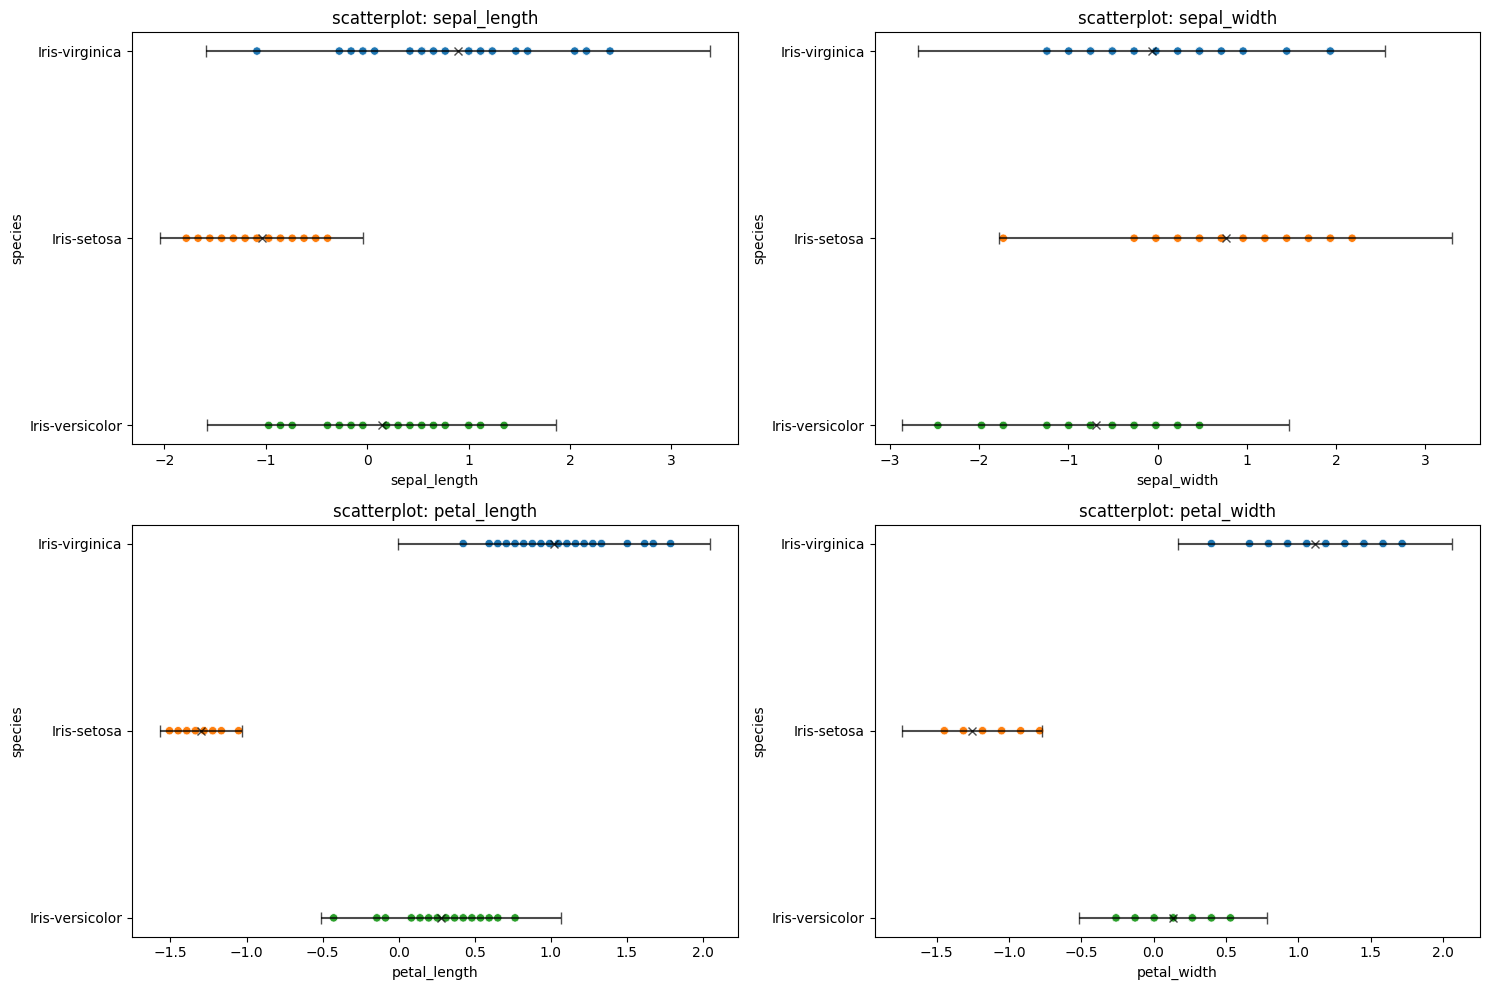

In [16]:
# scatterplot of features after normalization
n_vars = X_train.shape[1]
n_cols = int(np.ceil(n_vars/2))
n_rows = int(np.ceil(n_vars/n_cols))
stats = X_train.groupby(y_train).agg(['mean','std'])
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*5))
axes = ax.flatten()

for i, col in enumerate(X_train.columns):
    sns.scatterplot(data=X_train, x=col, y=y_train, hue=y_train,
                   ax=axes[i])
    axes[i].set_title(f"scatterplot: {col}")
    axes[i].legend().remove()
    
    for species in y_train.unique():
        mean_val = stats[col]['mean'][species]
        std = stats[col]['std'][species]
        axes[i].errorbar(x=mean_val, y=species, xerr=3*std, fmt='x', color='black', capsize=4, alpha=.7)
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

## Performing Multi-Class Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, StratifiedKFold

We will use GridSearchCV to search for the best hyperparameter values for our problem. This is a brute-force method, but, in our case, given the small dataset and simple algorithm, it does not require too much computation. The hyperparameter values to test are given below in `param_dict` dictionary.

In [18]:
param_dict = {'penalty': ["l2"],
             'dual': [False],
             'tol': [1e-5,1e-4,1e-3],
             'C': [0.01, 0.1, 1.0, 10.0],
             'class_weight': ['balanced', None],
             'random_state':[42],
             'solver':['lbfgs', 'newton-cg','sag', 'saga'],
             'max_iter':[3_000, 10_000],
             'multi_class':['multinomial'],
             'n_jobs': [-1]}

In `param_dict`:
- We use `penalty` of `l2` only, since that is the only choice supported by multiple solvers.
- `C` is also given a logarithmic scale. It represents the inverse of the regularization strength for this model.
- We check both `class_weight = balanced` and `None`. In sklearn, `class_weight` argument, when set to `balanced`, gives class instances weights inversely proportional to the classs frequencies. This is a very popular way of dealing with unbalanced class distributions - we can simply give the rarer instance greater weight, so that it's misclassification is more heavily penalized than the more frequent class.
- `random_state` is kept fixed for reproducability and standardization across different solvers.
- `solver` is given as argument, a list of all supported sklearn solvers.
- `max_iter`, as the name suggests, is the maximum number of iterations the solver is given to converge.
- Finally, the argument for `tol` specifies the tolerance for convergence, with a default value of `1e-4`. This is also varied over an order of magnitude to see if varying `tol` can help improve performance.

**Criteria for GridSearchCV**

We use `StratifiedKFold` to perform Stratified K-fold cross validation. This is because:

- The dataset is small, and so K-fold cross-validation is a good way to get performance estimates. It is also computationally feasible for the same reason.
- Stratification is done so that each of the K folds have the same distribution of the three classes as in the training set. This isn't important in the Iris dataset, where class imbalance doesn't exist, but in general is a good practice to handle class imbalance.

Note that we do not need the validation set since we are performing cross-validation anyway. It would be acceptable to merge the validation set with the training set, and use the cross-validation estimates of performance instead. However, in this example, we decide to have a validation set anyway, since it will provide another estimate of the performance of the model for us, and the problem is simple enough for the training set to give good enough performance as is.

In [19]:
grid_search = GridSearchCV(estimator=LogisticRegression(),
                          param_grid=param_dict,
                          cv=StratifiedKFold(n_splits=10),
                          scoring='f1_macro',
                          verbose=1,
                          return_train_score=True)

In [20]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0],
                         'class_weight': ['balanced', None], 'dual': [False],
                         'max_iter': [3000, 10000],
                         'multi_class': ['multinomial'], 'n_jobs': [-1],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                         'tol': [1e-05, 0.0001, 0.001]},
             return_train_score=True, scoring='f1_macro', verbose=1)

In [21]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_class_weight', 'param_dual', 'param_max_iter', 'param_multi_class', 'param_n_jobs', 'param_penalty', 'param_random_state', 'param_solver', 'param_tol', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [22]:
keys_of_interest = ['params','mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']
cv_results_dict = {}
for key in keys_of_interest:
    cv_results_dict[key] = grid_search.cv_results_[key]
cv_results_df = pd.DataFrame(cv_results_dict)

In [23]:
cv_results_df.head()

,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,"{'C': 0.01, 'class_weight': 'balanced', 'dual'...",0.870635,0.08505,0.885919,0.01073
1,"{'C': 0.01, 'class_weight': 'balanced', 'dual'...",0.870635,0.08505,0.885919,0.01073
2,"{'C': 0.01, 'class_weight': 'balanced', 'dual'...",0.870635,0.08505,0.885919,0.01073
3,"{'C': 0.01, 'class_weight': 'balanced', 'dual'...",0.870635,0.08505,0.885919,0.01073
4,"{'C': 0.01, 'class_weight': 'balanced', 'dual'...",0.870635,0.08505,0.885919,0.01073


In [24]:
best_series = cv_results_df.iloc[grid_search.best_index_]
print("Best Parameters:", best_series['params'])
print(f"Best Training Set Macro F1 Score: {best_series['mean_train_score']:.3f} +/- {best_series['std_train_score']:.3f}")
print(f"Best Cross-Validation Macro F1 Score: {best_series['mean_test_score']:.3f} +/- {best_series['std_test_score']:.3f}")

Best Parameters: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'max_iter': 3000, 'multi_class': 'multinomial', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 1e-05}
Best Training Set Macro F1 Score: 0.984 +/- 0.008
Best Cross-Validation Macro F1 Score: 0.966 +/- 0.052


One can see that there is no overfitting since the training set score and the (mean) cross-validation scores are within one standard deviation of each other. As mentioned before, we can see that even a small training set gets us good performance (cross-validation macro-$F_1 = 0.966 \pm 0.052$). This can be compared with the performance on the hold-out (validation) set and test set as well.

## Precision, Recall, F1 Score on Validation and Test Set

In [25]:
classifier = grid_search.best_estimator_

In [26]:
y_pred_val = classifier.predict(X_val)
y_pred_test = classifier.predict(X_test)

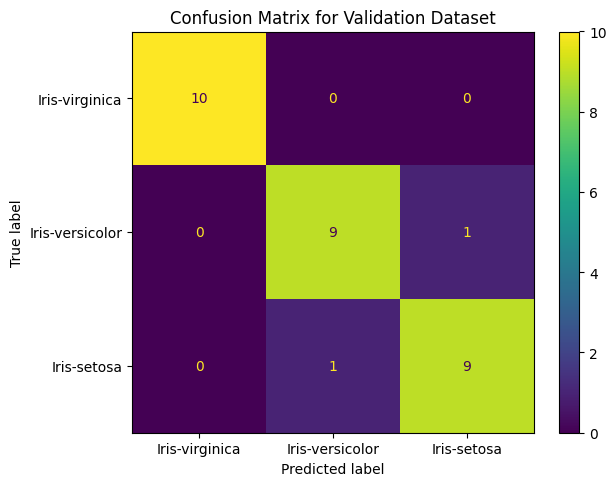

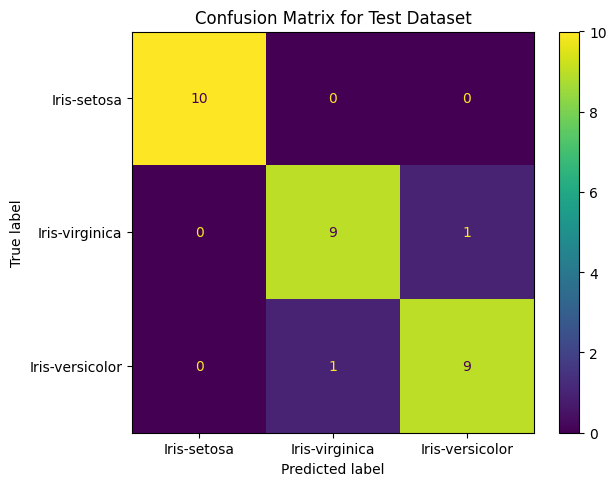

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_val), display_labels=y_val.unique()).plot(); # confusion matrix for validation dataset
plt.tight_layout()
plt.title("Confusion Matrix for Validation Dataset")
plt.show()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test), display_labels=y_test.unique()).plot(); # confusion matrix for test dataset
plt.tight_layout()
plt.title("Confusion Matrix for Test Dataset")
plt.show()

In [28]:
from sklearn.metrics import classification_report

In [29]:
print(classification_report(y_val, 
                     y_pred_val,
                     labels = ['Iris-versicolor', 'Iris-setosa', 'Iris-virginica'],
                     target_names = ['Iris-versicolor', 'Iris-setosa', 'Iris-virginica']))

                 precision    recall  f1-score   support

Iris-versicolor       0.90      0.90      0.90        10
    Iris-setosa       1.00      1.00      1.00        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



In [30]:
print(classification_report(y_test, 
                     y_pred_test,
                     labels = ['Iris-versicolor', 'Iris-setosa', 'Iris-virginica'],
                     target_names = ['Iris-versicolor', 'Iris-setosa', 'Iris-virginica']))

                 precision    recall  f1-score   support

Iris-versicolor       0.90      0.90      0.90        10
    Iris-setosa       1.00      1.00      1.00        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



As expected, the macro-f1 score for the validation and test datasets are within one standard deviation of the cross-validation scores. Notably, though, they are lower than the mean cross-validation score.

# Error Analysis

Let us take a look at the validation set examples that Logistic Regression **did** get wrong.

In [31]:
filt = y_val != y_pred_val
print(filt.sum())

2


In [32]:
pd.options.mode.copy_on_write = True
err_val = X_val[filt]
err_val['species'] = y_val[filt]
err_val['prediction'] = y_pred_val[filt]

In [33]:
err_val

,sepal_length,sepal_width,petal_length,petal_width,species,prediction
10,0.073530,0.469525,0.595072,0.795353,Iris-versicolor,Iris-virginica
27,0.189631,-1.973090,0.708659,0.399874,Iris-virginica,Iris-versicolor


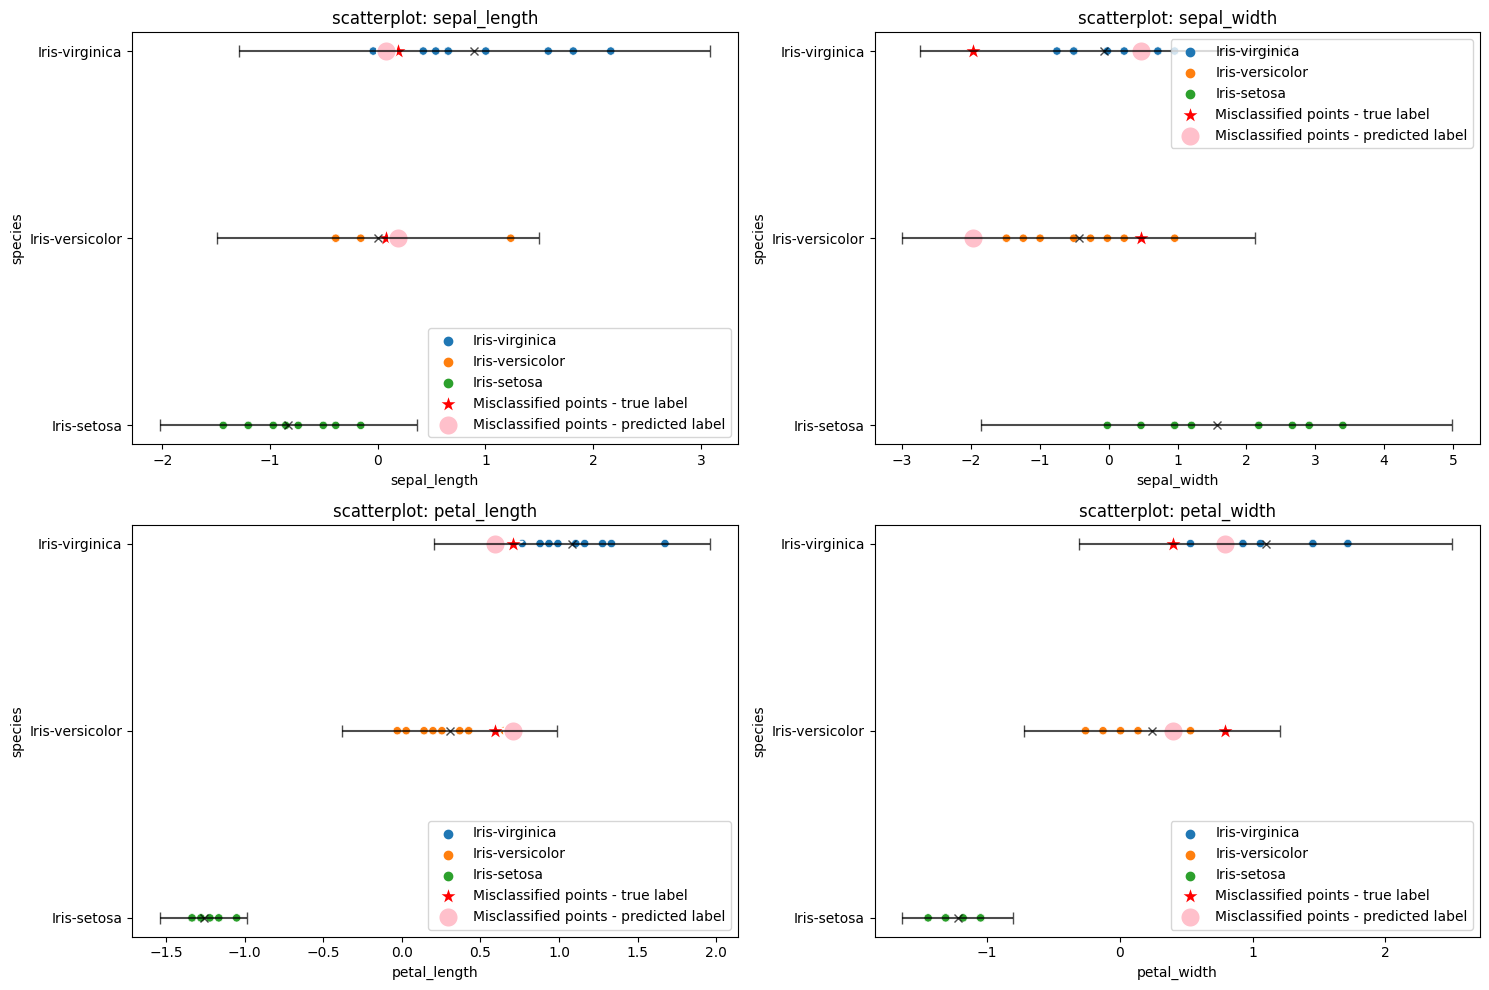

In [34]:
# scatterplot of features after normalization - X_val
n_vars = X_val.shape[1]
n_cols = int(np.ceil(n_vars/2))
n_rows = int(np.ceil(n_vars/n_cols))
stats = X_val.groupby(y_val).agg(['mean','std'])
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*5))
axes = ax.flatten()

for i, col in enumerate(X_val.columns):
    sns.scatterplot(data=X_val, x=col, y=y_val, hue=y_val,
                   ax=axes[i])
    axes[i].set_title(f"scatterplot: {col}")
    axes[i].legend().remove()
    
    for species in y_val.unique():
        mean_val = stats[col]['mean'][species]
        std = stats[col]['std'][species]
        axes[i].errorbar(x=mean_val, y=species, xerr=3*std, fmt='x', color='black', capsize=4, alpha=.7)
    
    if col in err_val.columns:
        sns.scatterplot(data=err_val, x=col, y='species', 
                        ax=axes[i], marker='*', color='red', s=200, label='Misclassified points - true label')
        sns.scatterplot(data=err_val, x=col, y='prediction', 
                        ax=axes[i], marker='o', color='pink', s=200, label='Misclassified points - predicted label')
    
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

We can see that:
- The misclassified points have very similar sepal and petal lengths.
- One of the misclassified points is quite far from the mean of `sepal_width` compared to the rest of the points in the same species (`iris-virginica`). Perhaps we should treat it as an outlier.